created by Ignacio Oguiza - email: oguiza@gmail.com

## 00. Purpose 😇

The purpose of this notebook is to show you how you can create a simple, state-of-the-art time series classification model using the great **fastai-v2** library in 4 steps:
1. Import libraries
2. Prepare data
3. Build learner
4. Train model

In general, there are 3 main ways to classify time series, based on the input to the neural network:

- raw data

- image data (encoded from raw data)

- feature data (extracted from raw data)

In this notebook, we will use the first approach. We will cover other approaches in future notebooks.

Throughout the notebook you will see this ✳️. It means there's some value you need to select.

## 01. Import libraries 📚

In [1]:
import tsai
from tsai.all import *
display(HTML("<style>.container {width:99% !important; }</style>"))

In [2]:
print('tsai       :', tsai.__version__)
print('fastai2    :', fastai2.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)
print('scipy      :', sp.__version__)
print('numpy      :', np.__version__)
print('pandas     :', pd.__version__)
print(f'Total RAM  : {bytes2GB(psutil.virtual_memory().total):5.2f} GB')
print(f'Used RAM   : {bytes2GB(psutil.virtual_memory().used):5.2f} GB')
print('n_cpus     :', cpus)
iscuda = torch.cuda.is_available()
if iscuda: print('device     : {} ({})'.format(device, torch.cuda.get_device_name(0)))
else: print('device     :', device)

tsai       : 0.0.4
fastai2    : 0.0.17
fastcore   : 0.1.17
torch      : 1.4.0
scipy      : 1.3.1
numpy      : 1.18.1
pandas     : 0.25.1
Total RAM  :  8.00 GB
Used RAM   :  3.89 GB
n_cpus     : 8
device     : cpu


## 02. Prepare data 🔢

### Download data ⬇️

In this notebook, we'll use one of the most widely used time series classification databases: UEA & UCR Time Series Classification Repository. As of Sep 2019 it contains 128 univariate datasets and 30 multivariate datasets.


In [3]:
pprint.pprint(get_UCR_univariate_list())

['ACSF1',
 'Adiac',
 'AllGestureWiimoteX',
 'AllGestureWiimoteY',
 'AllGestureWiimoteZ',
 'ArrowHead',
 'Beef',
 'BeetleFly',
 'BirdChicken',
 'BME',
 'Car',
 'CBF',
 'Chinatown',
 'ChlorineConcentration',
 'CinCECGTorso',
 'Coffee',
 'Computers',
 'CricketX',
 'CricketY',
 'CricketZ',
 'Crop',
 'DiatomSizeReduction',
 'DistalPhalanxOutlineAgeGroup',
 'DistalPhalanxOutlineCorrect',
 'DistalPhalanxTW',
 'DodgerLoopDay',
 'DodgerLoopGame',
 'DodgerLoopWeekend',
 'Earthquakes',
 'ECG200',
 'ECG5000',
 'ECGFiveDays',
 'ElectricDevices',
 'EOGHorizontalSignal',
 'EOGVerticalSignal',
 'EthanolLevel',
 'FaceAll',
 'FaceFour',
 'FacesUCR',
 'FiftyWords',
 'Fish',
 'FordA',
 'FordB',
 'FreezerRegularTrain',
 'FreezerSmallTrain',
 'Fungi',
 'GestureMidAirD1',
 'GestureMidAirD2',
 'GestureMidAirD3',
 'GesturePebbleZ1',
 'GesturePebbleZ2',
 'GunPoint',
 'GunPointAgeSpan',
 'GunPointMaleVersusFemale',
 'GunPointOldVersusYoung',
 'Ham',
 'HandOutlines',
 'Haptics',
 'Herring',
 'HouseTwenty',
 'Inli

In [4]:
pprint.pprint(get_UCR_multivariate_list())

['ArticularyWordRecognition',
 'AtrialFibrillation',
 'BasicMotions',
 'CharacterTrajectories',
 'Cricket',
 'DuckDuckGeese',
 'EigenWorms',
 'Epilepsy',
 'ERing',
 'EthanolConcentration',
 'FaceDetection',
 'FingerMovements',
 'HandMovementDirection',
 'Handwriting',
 'Heartbeat',
 'InsectWingbeat',
 'JapaneseVowels',
 'Libras',
 'LSST',
 'MotorImagery',
 'NATOPS',
 'PEMS-SF',
 'PenDigits',
 'PhonemeSpectra',
 'RacketSports',
 'SelfRegulationSCP1',
 'SelfRegulationSCP2',
 'SpokenArabicDigits',
 'StandWalkJump',
 'UWaveGestureLibrary']


In the case of UCR data it's very easy to get data loaded. Let's select a dataset. You can modify this and select any one from the previous lists (univariate of multivariate).

In [9]:
# dataset id
dsid = 'NATOPS'   # ✳️

In [10]:
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, verbose=True)

Dataset: NATOPS
X_train: (180, 24, 51)
y_train: (180,)
X_valid: (180, 24, 51)
y_valid: (180,) 



In the case of UCR data, they all come split into train and test. To keep the same splits we'll use this:

In [11]:
X = np.concatenate((X_train, X_valid))
y = np.concatenate((y_train, y_valid))
splits = (L(list(np.arange(len(X_train)))), L(list(np.arange(len(X_train), len(X)))))

☣️ **Something very important when you prepare your own data is that data needs to be in a 3-d array with the following format:**

1. Samples
2. Variables
3. Length (aka time steps)

All UEA & UCR Time Series Classification data have already been split between train and valid. When you use your own data, you'll have to split it yourself. We'll see examples of this in future notebooks.

### Prepare datasets 💿

The first step is to create datasets. This is very easy to do in v2. 

In TS classification problems, you will usually want to use an item tfm to transform y into categories.

We'll use inplace=True to preprocess data at dataset initialization. This will significantly spee up training. 

We can use inplace=True when:

- No transforms are applied to X, or
- The whole transformed X fits in memory

In [13]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

We'll now build the dataloaders that will create batches of data.

You will need to pass:

* datasets: usually 2 - train and valid -  or 1 - test or unlabeled- depending on the problem
* batch size(s): you may pass a single value (will will be appied to all dls, or different values, one for each dl.
* num workers: num_workers > 0 is used to preprocess batches of data so that the next batch is ready for use when the current batch has been finished. More num_workers would consume more memory usage but is helpful to speed up the I/O process. This will depend on your machine, dataset, etc. You may want to start with 0, and test other values to see how to train faster.

In [26]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], num_workers=0)

### Visualize data

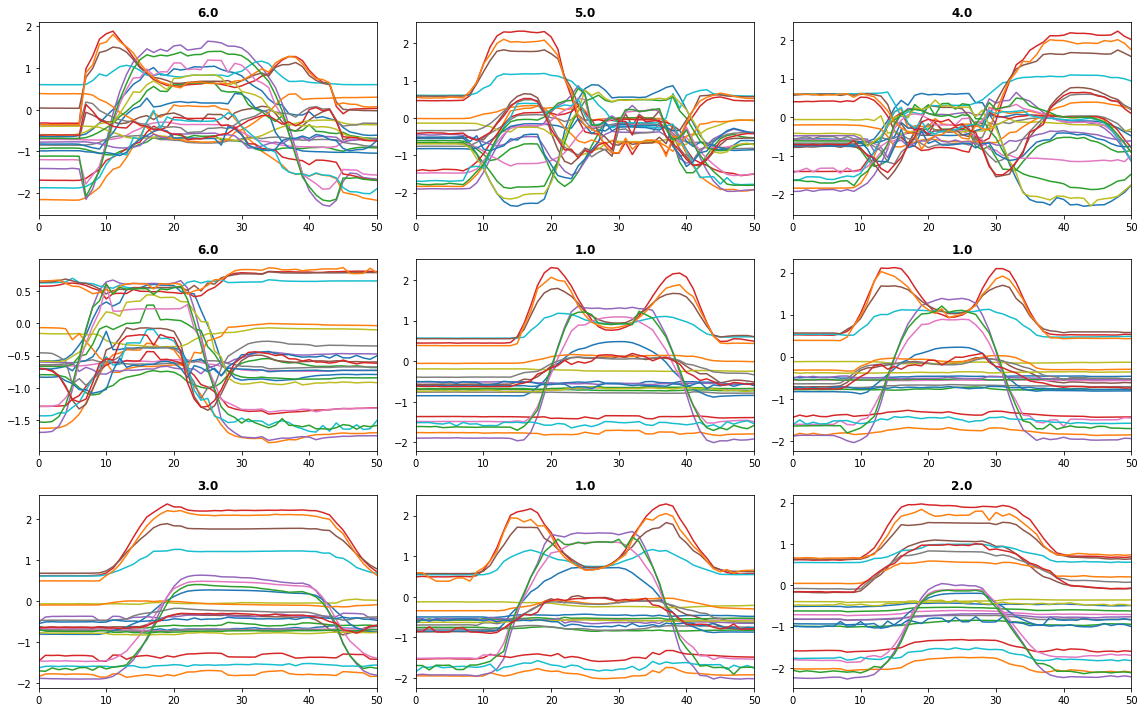

In [17]:
dls.show_batch()

## 03. Build learner 🏗

In [27]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.save('stage0')

## 04. Train model 🚵🏼‍

### LR find 🔎

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.0006918309954926372)

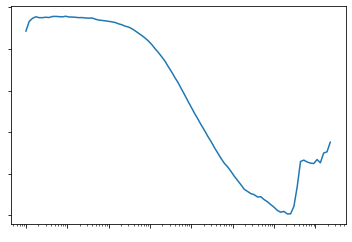

In [29]:
learn.load('stage0')
learn.lr_find()

### Train 🏃🏽‍♀️

In [33]:
learn.fit_one_cycle(25, lr_max=1e-3)
learn.save('stage1')

epoch,train_loss,valid_loss,accuracy,time
0,1.713168,1.771386,0.172222,00:05
1,1.625508,1.761336,0.194444,00:05
2,1.512967,1.739310,0.216667,00:05
3,1.359784,1.699674,0.238889,00:05
4,1.208967,1.635874,0.355556,00:05
5,1.076848,1.537473,0.511111,00:05
6,0.959943,1.408372,0.655556,00:05
7,0.865623,1.235865,0.761111,00:05
8,0.789699,1.064400,0.783333,00:05
9,0.726010,0.927352,0.766667,00:05


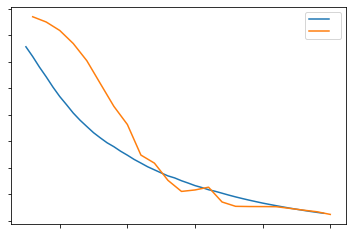

In [36]:
learn.recorder.plot_loss()

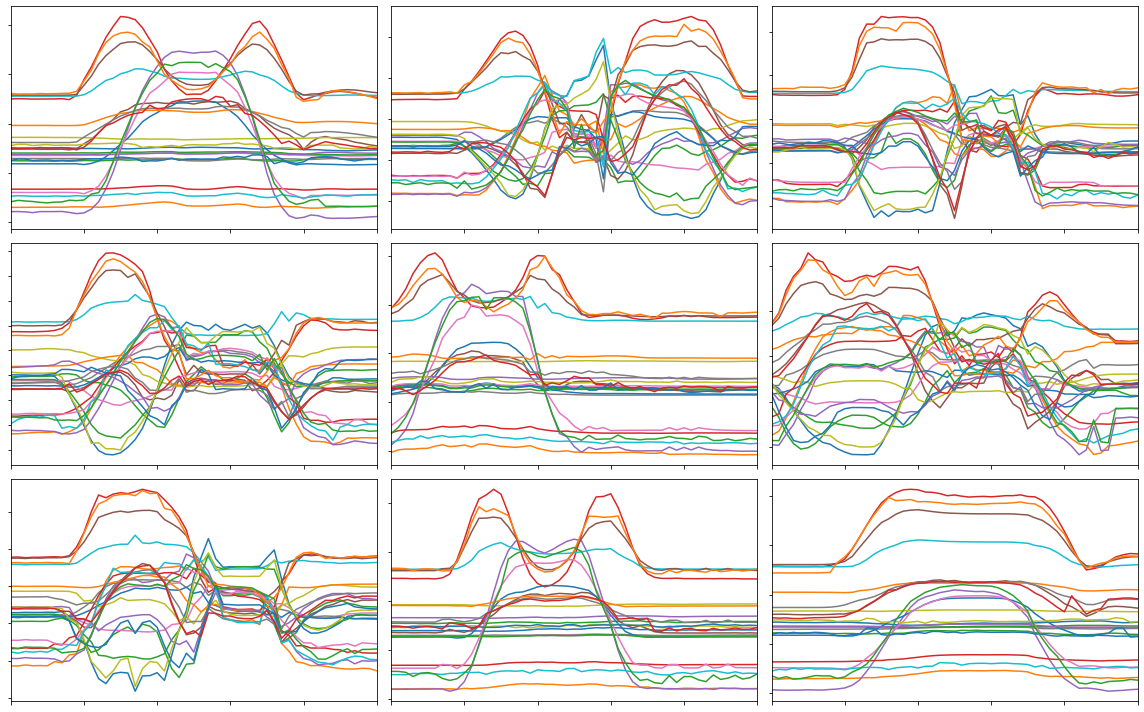

In [40]:
learn.show_results()

### Results

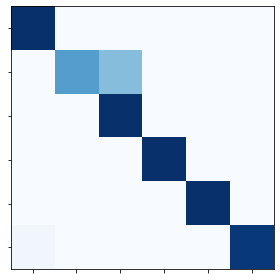

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()